<a href="https://colab.research.google.com/github/ramesh0805/CD/blob/main/Final_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
# Installs needed packages for the project, including kaleido for image saving
!pip install optuna lightgbm imbalanced-learn shap seaborn plotly kaleido

In [3]:
# Loads tools for data, ML, and plotting
import pandas as pd  # For handling data tables
import numpy as np  # For math operations
from sklearn.model_selection import train_test_split  # Splits data into train/test
from sklearn.preprocessing import StandardScaler  # Scales data to normal range
from sklearn.impute import SimpleImputer  # Fills missing values
from imblearn.over_sampling import ADASYN  # Balances uneven classes
from lightgbm import LGBMClassifier  # Machine learning model
from sklearn.metrics import roc_auc_score, accuracy_score  # Checks how good model is
import optuna  # Finds best model settings
import shap  # Explains model decisions
import matplotlib.pyplot as plt  # Makes basic plots
import seaborn as sns  # Makes nicer plots
import plotly.express as px  # Makes interactive plots
import warnings
warnings.filterwarnings('ignore')  # Stops warning messages

In [9]:
#read the dataset
train = pd.read_csv('application_train.csv')  # Loads data into a table
print("Dataset shape:", train.shape)  # Shows number of rows and columns
print(train.head())  # Shows first 5 rows

Dataset shape: (192188, 122)
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   
1      100003       0         Cash loans           F            N   
2      100004       0    Revolving loans           M            Y   
3      100006       0         Cash loans           F            N   
4      100007       0         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   
1               N             0          270000.0   1293502.5      35698.5   
2               Y             0           67500.0    135000.0       6750.0   
3               Y             0          135000.0    312682.5      29686.5   
4               Y             0          121500.0    513000.0      21865.5   

   ...  FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...  

In [10]:
# Cleans and prepares data for modeling
train = train.drop(columns=['SK_ID_CURR'])  # Removes ID column
numeric_cols = train.select_dtypes(include=np.number).columns  # Finds number columns
imputer = SimpleImputer(strategy='median')  # Sets up to fill missing with middle value
train[numeric_cols] = imputer.fit_transform(train[numeric_cols])  # Fills missing numbers
categorical_cols = train.select_dtypes(include='object').columns  # Finds text columns
train = pd.get_dummies(train, columns=categorical_cols)  # Turns text into numbers
print("Missing values after preprocessing:", train.isnull().sum().sum())  # Checks no missing left
print("New dataset shape:", train.shape)  # Shows new size after changes

Missing values after preprocessing: 0
New dataset shape: (192188, 245)


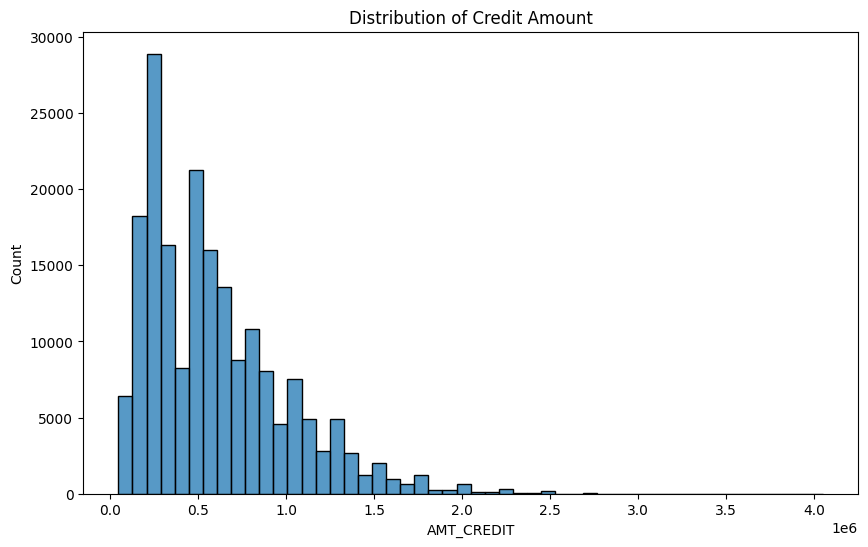

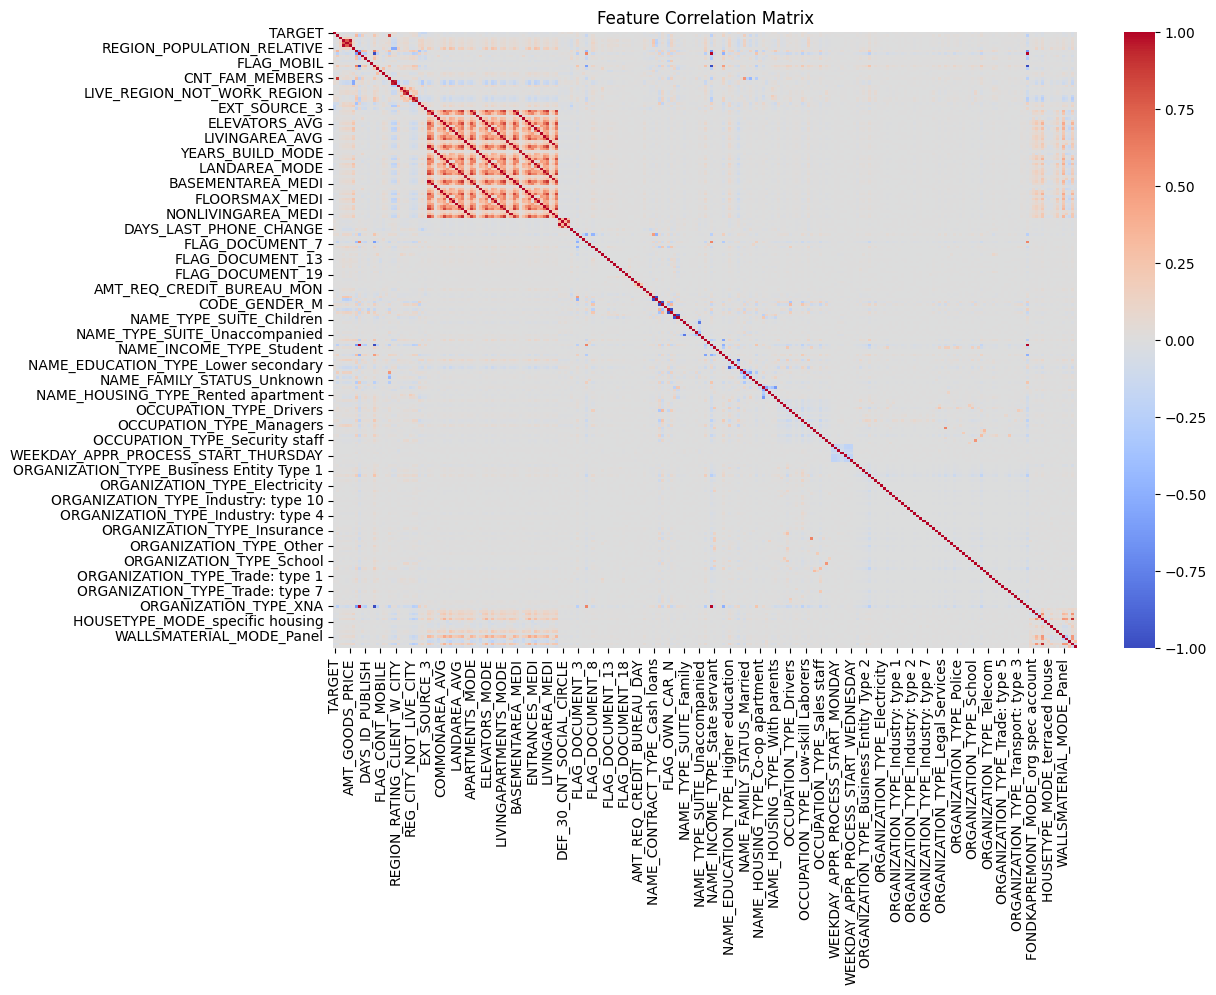

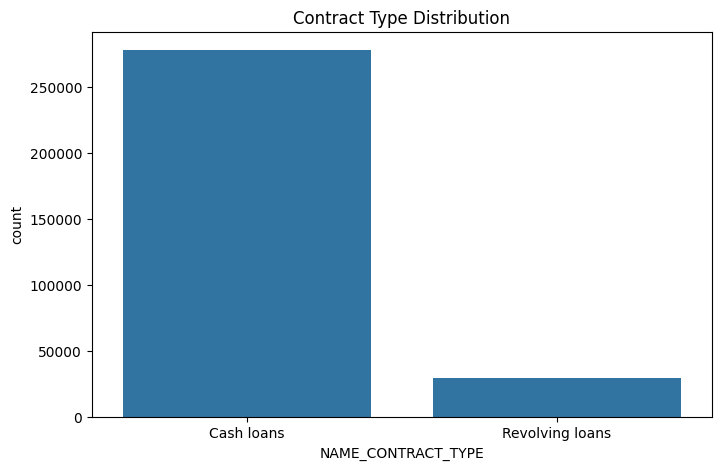

Missing values (%):
 AMT_ANNUITY                    0.003902
AMT_GOODS_PRICE                0.090403
NAME_TYPE_SUITE                0.420148
OWN_CAR_AGE                   65.990810
OCCUPATION_TYPE               31.345545
                                ...    
AMT_REQ_CREDIT_BUREAU_DAY     13.501631
AMT_REQ_CREDIT_BUREAU_WEEK    13.501631
AMT_REQ_CREDIT_BUREAU_MON     13.501631
AMT_REQ_CREDIT_BUREAU_QRT     13.501631
AMT_REQ_CREDIT_BUREAU_YEAR    13.501631
Length: 67, dtype: float64


In [12]:
# Makes plots to understand data
plt.figure(figsize=(10, 6))  # Sets plot size
sns.histplot(train['AMT_CREDIT'], bins=50)  # Shows spread of credit amounts
plt.title('Distribution of Credit Amount')  # Adds title
plt.savefig('amt_credit_hist.png')  # Saves picture
plt.show()  # Shows picture
plt.figure(figsize=(12, 8))  # Bigger size for next plot
sns.heatmap(train.corr(), cmap='coolwarm', annot=False)  # Shows how features connect
plt.title('Feature Correlation Matrix')  # Adds title
plt.savefig('correlation_heatmap.png')  # Saves picture
plt.show()  # Shows picture
raw_data = pd.read_csv('application_train.csv')  # Reloads original data
plt.figure(figsize=(8, 5))  # Sets size
sns.countplot(x='NAME_CONTRACT_TYPE', data=raw_data)  # Counts loan types
plt.title('Contract Type Distribution')  # Adds title
plt.savefig('contract_type_bar.png')  # Saves picture
plt.show()  # Shows picture
missing = raw_data.isnull().sum() / len(raw_data) * 100  # Finds % missing
print("Missing values (%):\n", missing[missing > 0])  # Shows missing info

In [13]:
# Adds a new feature to help model
train['DEBT_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL'].replace(0, np.nan)  # Makes debt-to-income ratio
train['DEBT_INCOME_RATIO'] = train['DEBT_INCOME_RATIO'].fillna(train['DEBT_INCOME_RATIO'].median())  # Fills missing with middle value
print("Sample of engineered feature:")  # Shows sample
print(train[['AMT_CREDIT', 'AMT_INCOME_TOTAL', 'DEBT_INCOME_RATIO']].head())  # Prints first 5 rows

Sample of engineered feature:
   AMT_CREDIT  AMT_INCOME_TOTAL  DEBT_INCOME_RATIO
0    406597.5          202500.0           2.007889
1   1293502.5          270000.0           4.790750
2    135000.0           67500.0           2.000000
3    312682.5          135000.0           2.316167
4    513000.0          121500.0           4.222222


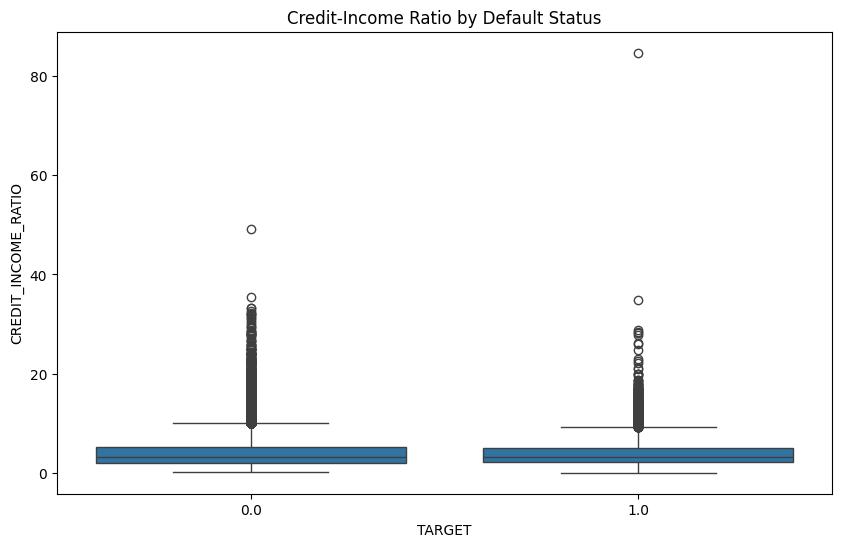

In [14]:
# Adds more features and a plot
train['CREDIT_INCOME_RATIO'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL'].replace(0, np.nan)  # Adds credit-to-income ratio
train['CREDIT_INCOME_RATIO'] = train['CREDIT_INCOME_RATIO'].fillna(train['CREDIT_INCOME_RATIO'].median())  # Fills missing
train['ANNUITY_INCOME_RATIO'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL'].replace(0, np.nan)  # Adds annuity-to-income ratio
train['ANNUITY_INCOME_RATIO'] = train['ANNUITY_INCOME_RATIO'].fillna(train['ANNUITY_INCOME_RATIO'].median())  # Fills missing
plt.figure(figsize=(10, 6))  # Sets plot size
sns.boxplot(x='TARGET', y='CREDIT_INCOME_RATIO', data=train)  # Plots ratio vs default
plt.title('Credit-Income Ratio by Default Status')  # Adds title
plt.savefig('credit_income_box.png')  # Saves picture
plt.show()  # Shows picture

In [15]:
# Splits data into inputs and output
X = train.drop(columns=['TARGET'])  # Takes all but target column
y = train['TARGET']  # Takes target column
print("X shape:", X.shape)  # Shows input size
print("y shape:", y.shape)  # Shows output size
print("Target distribution:\n", y.value_counts(normalize=True))  # Shows % of defaults

X shape: (192188, 247)
y shape: (192188,)
Target distribution:
 TARGET
0.0    0.918798
1.0    0.081202
Name: proportion, dtype: float64


In [16]:
# Makes data even between defaults and non-defaults
adasyn = ADASYN(random_state=42)  # Sets up balancing tool
X_balanced, y_balanced = adasyn.fit_resample(X, y)  # Balances the data
print("Balanced X shape:", X_balanced.shape)  # Shows new input size
print("Balanced y shape:", y_balanced.shape)  # Shows new output size
print("New target distribution:\n", pd.Series(y_balanced).value_counts(normalize=True))  # Shows new % split

Balanced X shape: (356220, 247)
Balanced y shape: (356220,)
New target distribution:
 TARGET
1.0    0.504289
0.0    0.495711
Name: proportion, dtype: float64


In [17]:
# Splits data and adjusts scale
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)  # Splits 80% train, 20% test
scaler = StandardScaler()  # Sets up scaling tool
X_train = scaler.fit_transform(X_train)  # Scales training data
X_test = scaler.transform(X_test)  # Scales test data
print("X_train shape:", X_train.shape)  # Shows training size
print("X_test shape:", X_test.shape)  # Shows test size

X_train shape: (284976, 247)
X_test shape: (71244, 247)


In [18]:
# Finds best settings for model
def objective(trial):  # Function to test settings
    params = {  # List of settings to try
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),  # How fast to learn
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),  # How many leaves in trees
        'max_depth': trial.suggest_int('max_depth', 3, 15),  # How deep trees go
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),  # Min data per leaf
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # % of data used
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # % of features used
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),  # Number of trees
        'objective': 'binary',  # Yes/no prediction
        'random_state': 42,  # Keeps results same
        'verbose': -1  # Keeps quiet
    }
    model = LGBMClassifier(**params)  # Makes model with settings
    model.fit(X_train, y_train)  # Trains model
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Gets probability predictions
    auc = roc_auc_score(y_test, y_pred_proba)  # Checks how good it is
    return auc  # Returns score
study = optuna.create_study(direction='maximize')  # Starts finding best score
study.optimize(objective, n_trials=4)  # Tries 50 times
print("Best AUC-ROC:", study.best_value)  # Shows best score
print("Best parameters:", study.best_params)  # Shows best settings

[I 2025-04-01 17:47:27,050] A new study created in memory with name: no-name-7a0ddb5a-2250-41e2-a196-574a205af3cc
[I 2025-04-01 17:48:30,028] Trial 0 finished with value: 0.9729449747560733 and parameters: {'learning_rate': 0.22953862913999357, 'num_leaves': 40, 'max_depth': 11, 'min_child_samples': 46, 'subsample': 0.578846373070073, 'colsample_bytree': 0.9741291545238802, 'n_estimators': 450}. Best is trial 0 with value: 0.9729449747560733.
[I 2025-04-01 17:49:40,662] Trial 1 finished with value: 0.9736467270073017 and parameters: {'learning_rate': 0.04903611768598614, 'num_leaves': 29, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.8360032945686153, 'colsample_bytree': 0.9278843182264294, 'n_estimators': 442}. Best is trial 1 with value: 0.9736467270073017.
[I 2025-04-01 17:51:33,379] Trial 2 finished with value: 0.9471121405976559 and parameters: {'learning_rate': 0.010855236017457229, 'num_leaves': 80, 'max_depth': 9, 'min_child_samples': 47, 'subsample': 0.64108538372042

Best AUC-ROC: 0.9736467270073017
Best parameters: {'learning_rate': 0.04903611768598614, 'num_leaves': 29, 'max_depth': 9, 'min_child_samples': 33, 'subsample': 0.8360032945686153, 'colsample_bytree': 0.9278843182264294, 'n_estimators': 442}


In [19]:
# Trains model with best settings and checks it
best_params = study.best_params  # Gets best settings
final_model = LGBMClassifier(**best_params)  # Makes final model
final_model.fit(X_train, y_train)  # Trains it
y_pred = final_model.predict(X_test)  # Predicts yes/no
y_pred_proba = final_model.predict_proba(X_test)[:, 1]  # Predicts probabilities
final_auc = roc_auc_score(y_test, y_pred_proba)  # Checks AUC score
final_accuracy = accuracy_score(y_test, y_pred)  # Checks % correct
print(f"Final AUC-ROC on test set: {final_auc:.4f}")  # Shows AUC
print(f"Final Accuracy on test set: {final_accuracy:.4f}")  # Shows accuracy

Final AUC-ROC on test set: 0.9741
Final Accuracy on test set: 0.9146


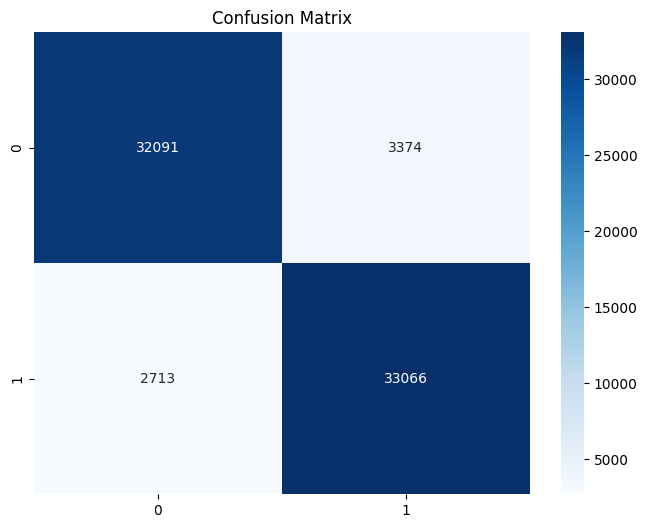

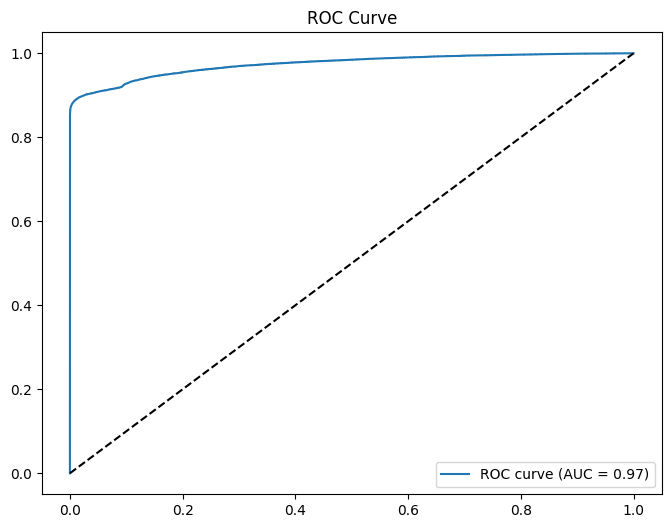

In [20]:
# Makes extra plots to check model
from sklearn.metrics import confusion_matrix, roc_curve, auc  # Tools for more checks
cm = confusion_matrix(y_test, y_pred)  # Shows right/wrong predictions
plt.figure(figsize=(8, 6))  # Sets size
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # Plots confusion matrix
plt.title('Confusion Matrix')  # Adds title
plt.savefig('confusion_matrix.png')  # Saves picture
plt.show()  # Shows picture
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)  # Gets points for ROC curve
roc_auc = auc(fpr, tpr)  # Finds area under curve
plt.figure(figsize=(8, 6))  # Sets size
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')  # Plots ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # Adds straight line
plt.title('ROC Curve')  # Adds title
plt.legend()  # Adds label
plt.savefig('roc_curve.png')  # Saves picture
plt.show()  # Shows picture

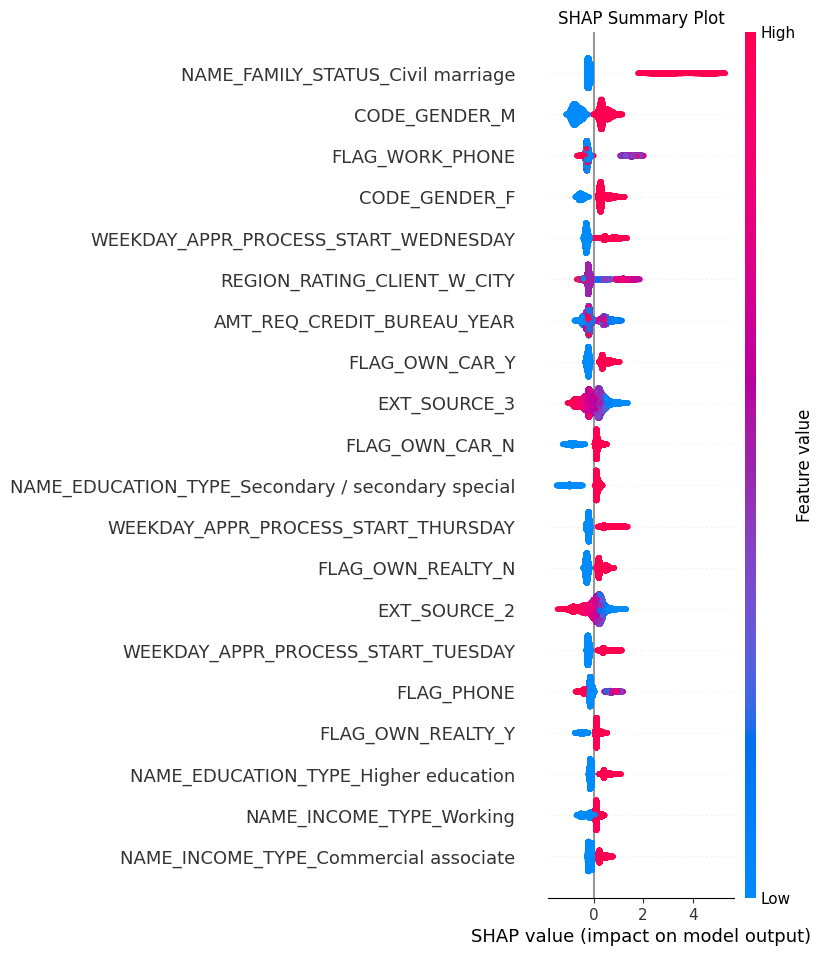

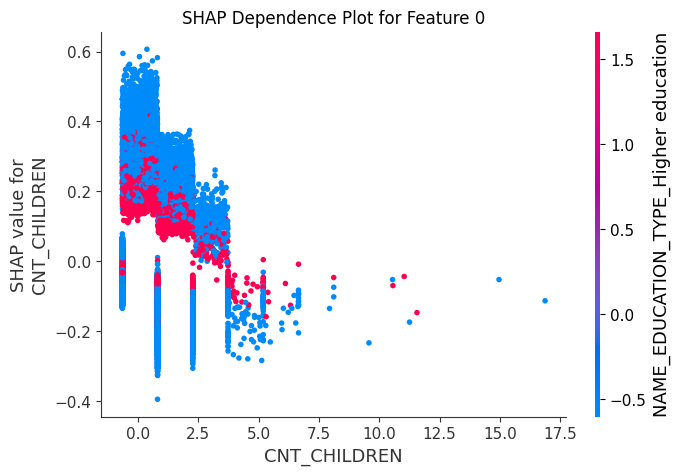

In [21]:
# Shows what affects model predictions
explainer = shap.TreeExplainer(final_model)  # Sets up tool to explain model
shap_values = explainer.shap_values(X_test)  # Gets values for explanations
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)  # Plots all feature impacts
plt.title("SHAP Summary Plot")  # Adds title
plt.show()  # Shows picture
shap.dependence_plot(0, shap_values, X_test, feature_names=X.columns, show=False)  # Plots top feature effect
plt.title("SHAP Dependence Plot for Feature 0")  # Adds title
plt.show()  # Shows picture

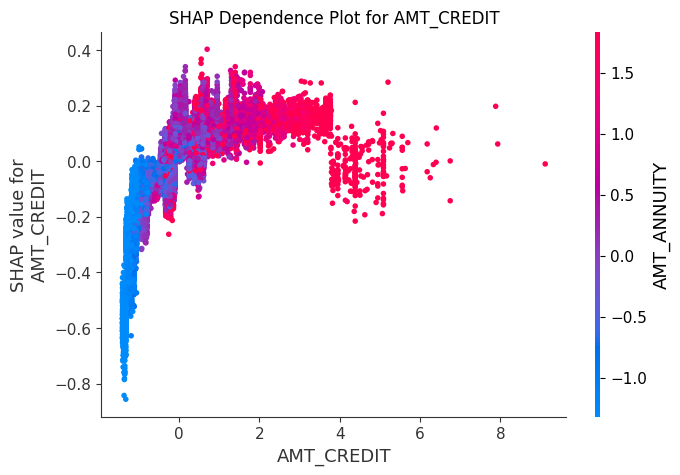

In [22]:
# Shows how credit amount affects predictions
shap.dependence_plot('AMT_CREDIT', shap_values, X_test, feature_names=X.columns, show=False)  # Plots credit amount effect
plt.title("SHAP Dependence Plot for AMT_CREDIT")  # Adds title
plt.savefig('shap_dependence_amt_credit.png')  # Saves picture
plt.show()  # Shows picture

In [25]:
# Makes sure plots work in Colab
%matplotlib inline
fig1 = optuna.visualization.plot_optimization_history(study)  # Plots score over tries
fig1.show()  # Shows picture
fig2 = optuna.visualization.plot_param_importances(study)  # Plots which settings matter
fig2.show()  # Shows picture
print("Cell 12 executed successfully.")  # Says it worked

Cell 12 executed successfully.


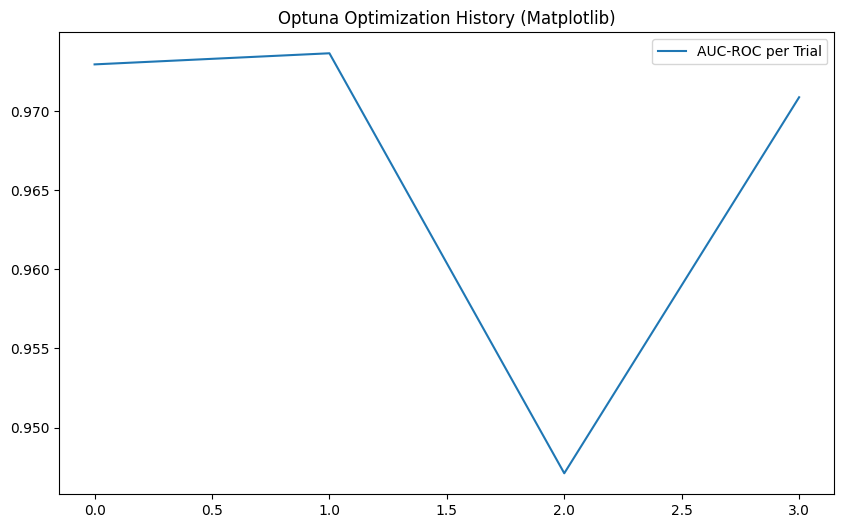

In [34]:
# Saves tuning plots using Matplotlib, no kaleido needed
import matplotlib.pyplot as plt

# Plot and save optimization history
plt.figure(figsize=(10, 6))  # Sets size
trials = study.trials_dataframe()  # Gets trial data
plt.plot(trials['number'], trials['value'], 'bo-', label='Objective Value')  # Plots all trials
plt.plot(trials['number'], trials['value'].cummax(), 'r--', label='Best Value')  # Plots best so far
plt.title('Optuna Optimization History')  # Adds title
plt.xlabel('Trial')  # Labels x-axis
plt.ylabel('Objective Value (AUC-ROC)')  # Labels y-axis
plt.legend()  # Adds label
plt.savefig('optuna_history.png')  # Saves picture
plt.close()  # Closes plot

# Plot and save parameter importance
plt.figure(figsize=(10, 6))  # Sets size
param_importances = optuna.importance.get_param_importances(study)  # Gets importance data
params = list(param_importances.keys())  # Parameter names
values = list(param_importances.values())  # Importance values
plt.bar(params, values)  # Plots bars
plt.title('Parameter Importance')  # Adds title
plt.xticks(rotation=45)  # Rotates labels
plt.ylabel('Importance')  # Labels y-axis
plt.savefig('optuna_param_importance.png')  # Saves picture
plt.close()  # Closes plot

# Extra Matplotlib plot
plt.figure(figsize=(10, 6))  # Sets size
plt.plot(trials['value'], label='AUC-ROC per Trial')  # Plots score trend
plt.title('Optuna Optimization History (Matplotlib)')  # Adds title
plt.legend()  # Adds label
plt.savefig('optuna_history_matplotlib.png')  # Saves picture
plt.show()  # Shows picture